# Testing emission models

This jupyter notebook is to test different emission models, including a Gaussian mixture, a directional model (VMF), and our novely desinged Gaussian Mixture with exponential signal strength. The main porpuse of this short example is trying to show the three models are correctly fitted via an EM procedure.

<br>
<br>

## General EM process for emission models fitting

Given the Markov property, the emission models specify the log probability of the observed data as a function of $\mathbf{u}$.  

$$
\log p(\mathbf{Y}|\mathbf{U};\theta_E)=\sum_i \log p(\mathbf{y}_i|\mathbf{u}_i;\theta_E)
$$

Furthermore, assuming that $\mathbf{u}_i$ is a one-hot encoded indicator variable (parcellation model), we can write the expected emission log-likelihood as: 
$$
\mathcal{L}_E=\langle \log p(\mathbf{Y}|\mathbf{U};\theta_E)\rangle =\sum_i \sum_k \langle u_i^{(k)}\log p(\mathbf{y}_i|u_i=k;\theta_E) \rangle
$$
In the E-step the emission model simply passes $p(\mathbf{y}_i|\mathbf{u}_i;\theta_E)$ as a message to the arrangement model. In the M-step, $q(\mathbf{u}_i) = \langle \mathbf{u}_i \rangle$ is passed back, and the emission model optimizes the above quantity in respect to $\theta_E $.

<br>
<br>

## Emission models description

### 1. Gaussian Mixture model (GMM)

Under the Gaussian mixture model, we model the emissions as a Gaussian with a parcel-specific mean ($\mathbf{v}_k$), and with equal isotropic variance across parcels and observations:

$$
p(\mathbf{y_i}|u^{(k)};\theta_E) = \frac{1}{(2\pi)^{N/2}(\sigma^{2})^{N/2}}\rm{exp}\{-\frac{1}{2\sigma^{2}}(y_{i}-\mathbf{v}_k)^T(y_{i}-\mathbf{v}_k)\}
$$

Then we can calculate the expected emission log likelihood, and update the parameters $\theta_E = \{\mathbf{v}_1,...,\mathbf{v}_K,\sigma^2\}$ in the $M$ step. 

### 2. von-Mises Fisher Mixture model (VMF)
For a $N$-dimensional data $\mathbf{y} (||\mathbf{y}||_2=1) $ the probability density function of von Mises-Fisher distribution is defined as following,

$$
V_N(\mathbf{y}|\mathbf{v}_k,\kappa) = C_N(\kappa)exp(\kappa\mathbf{v}_k^{T}\mathbf{y})
$$

where $\mathbf{v}_k$ denotes the mean direction (unit vectors for each parcels), $\kappa$ indicates the concentration parameter ($\kappa\geqslant0$), which is joint over all parcels. $C_N(\kappa) = \frac{\kappa^{N/2-1}}{(2\pi)^{N/2}I_{N/2-1}(\kappa)}$ is the normalization constant where $I_r(.)$ refers to the modified Bessel function of the $r$ order. 

Now, we update the parameters $\theta$ of the von-Mises mixture in the $M$ step by maximizing $\mathcal{L}_E$  in respect to the parameters in von-Mises mixture $\theta_{k}=\{\mathbf{v}_{k},\kappa\}$. (Note: the updates only consider a single subject).

### 3. Gaussian Mixture model with exponential signal strength (GMM_exp)

One issue of the functional activation is that the signal-to-noise ratio (SNR) can be quite different across different participants, and voxels, with many voxels having relatively low SNR. We model this signal to noise for each brain location (and subject) as $s_i \sim Exp(\theta_{\beta s})$. Therefore the probability model for exponential (later on replaced by gamma) is defined as:

$$
p(s_i|\theta) = \beta e^{-\beta s_i}
$$

Overall, the expected signal at each brain location is then $\rm{E}(\mathbf{y}_i)=\mathbf{u}_i^T \mathbf{V}s_i$. Finally, relative to the signal, we assume that the noise is distributed i.i.d Gaussian with $\boldsymbol{\epsilon}_i \sim Normal(0,\mathbf{I}_K\theta_{\sigma s})$.

Here, the proposal distribution $q(u_{i}^{(k)},s_{i}|\mathbf{y}_{i})$ is now a multivariate distribution across $u_i$ and $s_i$. Thus, the *expected emission log likelihood* $\mathcal{L}_E(q, \theta)$ is defined as:

$$
\mathcal{L}_E = \langle\sum_i\log p(\mathbf{y}_i, s_i|u_i; \theta_E)\rangle_{q}
$$

We then update the parameters $\theta$ of the Gaussians/Exp mixture in the $M$ step. The parameters of the gaussian mixture model are $\theta_{E} = \{\mathbf{v}_{1},...,\sigma^{2},\beta\}$ . 

<br>
<br>

## Fitting model using generated data

Here we will fit the three emission model by given the true generated data from each model. Since the main propose is to test the emission models standalone, we freeze the arrangement model to use `Independent arrangement model` for all model fitting. It means each brain location has no spatial relations with nearby or all other location. 

In [3]:
import os
import sys 
sys.path.append(os.path.abspath('..'))
import numpy as np
import matplotlib.pyplot as plt
import torch as pt

import arrangements as ar
import emissions as em
import full_model as fm
from test_emissions import generate_data

# Some basic experimental settings throught the three emission models
K=5
P=1000
N=40
num_sub=10
max_iter=50


## 1. Fitting GMM

The testing process for each of the emission model is quiet similar as shown below. First, we initialize the true arrangement model and emission model with the true parameters. Secondly, we generate the true data from the true model, then compute the true emission log-likelihood for later use. Thirdly, we create another arrangement/emission model for data fitting. Lastly, we run EM algorithm for optimizing the model parameters.

In [4]:
# Step 1: Set the true model to some interesting value
arrangeT = ar.ArrangeIndependent(K=K, P=P, spatial_specific=False, remove_redundancy=False)
emissionT = em.MixGaussian(K=K, N=N, P=P)
# emissionT.random_params()

# Step 2: Generate data by sampling from the above model
U = arrangeT.sample(num_subj=num_sub)
Y = emissionT.sample(U)

# Step 2.1: Compute the log likelihood from the true model
theta_true = np.concatenate([emissionT.get_params(), arrangeT.get_params()])
T = fm.FullModel(arrangeT, emissionT)
T, loglike_true, theta, _ = T.fit_em(Y=Y, iter=1, tol=0.00001)

# Step 3: Generate new models for fitting
arrangeM = ar.ArrangeIndependent(K=K, P=P, spatial_specific=False, remove_redundancy=False)
emissionM = em.MixGaussian(K=K, N=N, P=P)

# Step 4: Estimate the parameter thetas to fit the new model using EM
M = fm.FullModel(arrangeM, emissionM)
M, ll, theta, _ = M.fit_em(Y=Y, iter=max_iter, tol=0.00001)

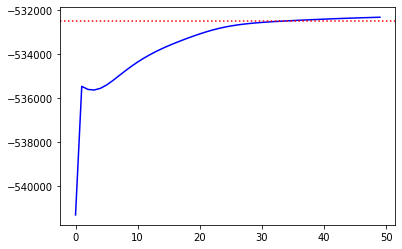

In [5]:
from test_emissions import _plot_diff, _plot_loglike, _plt_single_param_diff

_plot_loglike(np.trim_zeros(ll, 'b'), loglike_true, color='b')

This is the curve of emission log-likelihood by iterations.

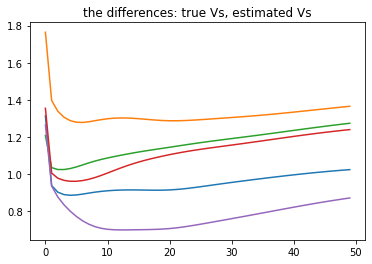

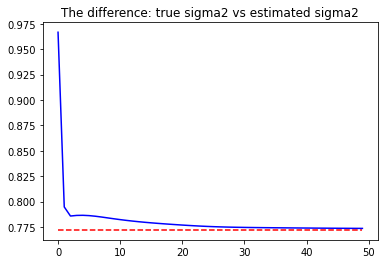

In [6]:
_plot_diff(theta_true[0:N*K], theta[:, 0:N*K], K, name='V')
_plt_single_param_diff(theta_true[-1-K], np.trim_zeros(theta[:, -1-K], 'b'), name='sigma2')

Here, we also plot the difference (distance) between the true Vs and the estimated Vs in the upper figure, and plot the true sigma vs. the estimated signma square at the bottom figure.

## 2. Fitting VMF

The process for the rest two emission models are basically the same. To save ink, I just call pre-defined testing function to run the data fitting.

Done.


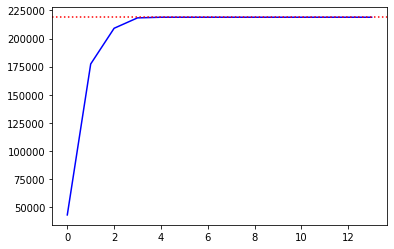

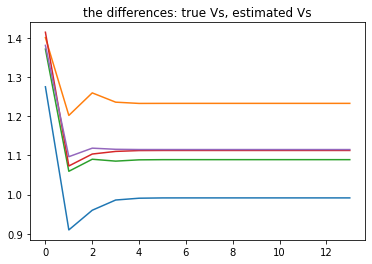

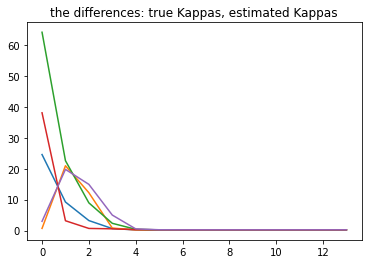

In [9]:
from test_emissions import _simulate_full_VMF
_simulate_full_VMF(K=K, P=P, N=N, num_sub=num_sub, max_iter=max_iter)

## 2. Fitting GMM_exp



[-1.18767828e-01  1.36710376e-01 -7.55694658e-02 -2.09107727e-01
  1.76420867e-01  2.72038877e-01 -4.24980313e-01 -9.71704647e-02
 -1.74258158e-01 -1.23926140e-01  3.54784168e-02  2.35023610e-02
 -1.42692402e-01 -2.23354116e-01 -1.53210565e-01  1.48688396e-02
 -1.18653767e-01  2.13688925e-01 -1.92743056e-02  1.44486040e-01
 -1.95572097e-02 -1.52002305e-01 -2.78694928e-01 -1.00645512e-01
 -2.56802559e-01 -1.29013389e-01 -4.83832173e-02  4.52696323e-01
 -1.48855466e-02 -4.05679680e-02 -2.01552197e-01 -5.66497482e-02
 -4.49790299e-04  9.76969898e-02 -9.92196351e-02  5.37558645e-02
 -2.03971460e-01 -2.15986632e-02  4.41430062e-02  1.41734052e-02
  6.14254363e-02 -1.61621392e-01  3.34477276e-02 -2.60168333e-02
  2.91357577e-01  3.86214852e-02  1.02671422e-02  1.30942106e-01
  2.26191983e-01 -3.82093899e-02  1.35586768e-01  5.98951727e-02
 -1.96883023e-01  9.54630598e-03 -7.42314160e-02 -4.41075601e-02
 -8.05984959e-02 -3.22291069e-02  1.23286538e-01  2.36015335e-01
 -3.44900280e-01 -1.33243

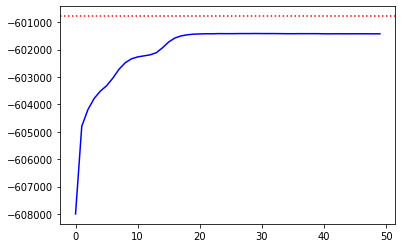

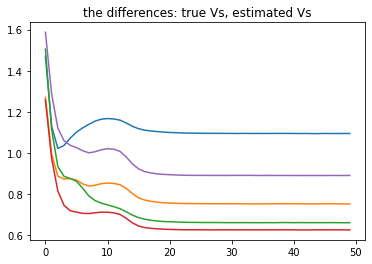

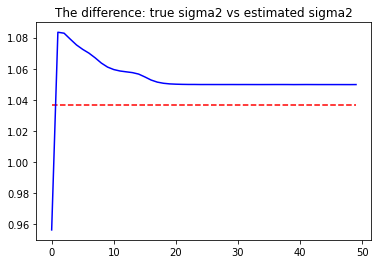

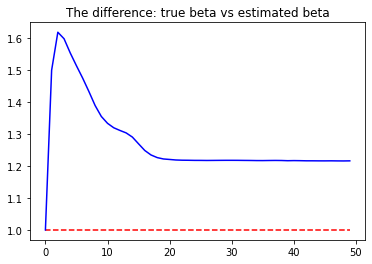

In [11]:
from test_emissions import _simulate_full_GME
_simulate_full_GME(K=K, P=P, N=N, num_sub=num_sub, max_iter=max_iter)